In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from classificatiom_model import EarlyStopping, ModelSaver,train_classification_model,plot_learning_curves
from classificatiom_model import evaluate_classification_model as evaluate_model

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# 创建一个随机输入张量，模拟特征图
# 形状为 [1, 3, 6, 6]，表示1个样本，3个通道，6x6的特征图
input_tensor = torch.randn(1, 3, 6, 6)
print("输入张量的形状:", input_tensor.shape)

# 创建 AdaptiveAvgPool2d 层，指定输出大小为 2x2
adaptive_pool = nn.AdaptiveAvgPool2d(output_size=(2, 2))

# 对输入张量进行自适应平均池化
output_tensor = adaptive_pool(input_tensor)
print("输出张量的形状:", output_tensor.shape)

输入张量的形状: torch.Size([1, 3, 6, 6])
输出张量的形状: torch.Size([1, 3, 2, 2])


In [3]:
import json
token = {"username":"eviltrashcan","key":"5a0836e4ef86086fdadf624206bd1421"}
with open('/content/kaggle.json', 'w') as file:
  json.dump(token, file)

In [4]:
!cat /content/kaggle.json

{"username": "eviltrashcan", "key": "5a0836e4ef86086fdadf624206bd1421"}

In [5]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v /content

- path is now set to: /content


In [6]:
!kaggle competitions download -c cifar-10

 96% 684M/715M [00:03<00:00, 98.8MB/s]
100% 715M/715M [00:03<00:00, 199MB/s] 


In [7]:
!unzip /content/competitions/cifar-10/cifar-10.zip

Archive:  /content/competitions/cifar-10/cifar-10.zip
  inflating: sampleSubmission.csv    
  inflating: test.7z                 
  inflating: train.7z                
  inflating: trainLabels.csv         


In [8]:
%pip install py7zr
import py7zr
a =py7zr.SevenZipFile(r'./train.7z','r')
a.extractall(path=r'./competitions/cifar-10/')
a.close()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.9/412.9 kB 38.5 MB/s eta 0:00:00


In [9]:
!ls competitions/cifar-10/train|wc -l

50000


In [10]:
# 加载CIFAR-10数据集
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

# 定义CIFAR-10数据集类
class CIFAR10Dataset(Dataset):
    def __init__(self, img_dir, labels_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform

        # 读取标签文件，read_csv默认读取第一行作为列名
        self.labels_df = pd.read_csv(labels_file)
        self.img_names = self.labels_df.iloc[:, 0].values.astype(str)  # 第一列是图片名称，确保为字符串类型

        # 类别名称字典，使用字典可以提高查找速度
        self.class_names_dict = {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3,
                                 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
        # 将文本标签转换为数字ID
        self.labels = [self.class_names_dict[label] for label in self.labels_df.iloc[:, 1].values]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx] + '.png') #图片路径
        image = Image.open(img_path) #打开图片
        label = self.labels[idx]

        if self.transform:
            image_tensor = self.transform(image)

        return image_tensor, label

# 定义数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4917, 0.4823, 0.4467), (0.2024, 0.1995, 0.2010))
])

# colab加载CIFAR-10数据集
img_dir = r"competitions/cifar-10/train"
labels_file = r"./trainLabels.csv"

# img_dir = r"D:\BaiduNetdiskDownload\1.Python11期\深度学习代码\cifar-10\train"
# labels_file = r"D:\BaiduNetdiskDownload\1.Python11期\深度学习代码\cifar-10\trainLabels.csv"
full_dataset = CIFAR10Dataset(img_dir=img_dir, labels_file=labels_file, transform=transform)

# 定义类别名称
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 划分训练集和验证集
train_size = 45000
val_size = 5000
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset,
    [train_size, val_size],
    generator=generator
)

# 查看数据集基本信息
print(f"完整数据集大小: {len(full_dataset)}")
print(f"训练集大小: {len(train_dataset)}")
print(f"验证集大小: {len(val_dataset)}")


完整数据集大小: 50000
训练集大小: 45000
验证集大小: 5000


In [11]:
# 创建数据加载器
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True #打乱数据集，每次迭代时，数据集的顺序都会被打乱
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)


In [12]:
# 构建ResNet模型
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    """
    ResNet的基本块
    包含两个3x3卷积层和一个跳跃连接(shortcut connection)
    """
    expansion = 1  # 输出通道数相对于输入通道数的扩展倍数

    def __init__(self, in_channels, out_channels, stride=1):
        """
        初始化基本块

        参数:
            in_channels: 输入特征图的通道数
            out_channels: 输出特征图的通道数
            stride: 第一个卷积层的步长，用于下采样
        """
        super(BasicBlock, self).__init__()
        # 第一个卷积层，可能用于下采样(当stride>1时)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)  # 批归一化层

        # 第二个卷积层，保持特征图大小不变
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)  # 批归一化层

        # 跳跃连接，当输入输出维度不匹配时需要进行调整
        self.shortcut = nn.Sequential()  # 默认为恒等映射
        if stride != 1 or in_channels != out_channels:
            # 使用1x1卷积调整通道数和特征图大小
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        """前向传播"""
        # 主路径
        out = F.relu(self.bn1(self.conv1(x)))  # 第一个卷积+BN+ReLU
        out = self.bn2(self.conv2(out))        # 第二个卷积+BN

        # 残差连接：将输入经过shortcut后与主路径结果相加
        out += self.shortcut(x)
        out = F.relu(out)  # 最终的ReLU激活
        return out

class ResNet(nn.Module):
    """
    ResNet模型
    由多个层组成，每层包含多个基本块
    """
    def __init__(self, block, num_blocks, num_classes=10):
        """
        初始化ResNet

        参数:
            block: 基本块类型(BasicBlock)
            num_blocks: 列表，指定每层中基本块的数量
            num_classes: 分类类别数
        """
        super(ResNet, self).__init__()
        self.in_channels = 64  # 初始通道数

        # 初始卷积层
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # 构建ResNet的4个层级，每个层级包含多个基本块
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)   # 输出大小: 32x32
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)  # 输出大小: 16x16
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)  # 输出大小: 8x8
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)  # 输出大小: 4x4

        # 全连接分类层
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        """
        构建包含多个基本块的层

        参数:
            block: 基本块类型
            out_channels: 输出通道数
            num_blocks: 该层中基本块的数量
            stride: 第一个基本块的步长(用于下采样)

        返回:
            nn.Sequential: 包含多个基本块的层
        """
        # 第一个块可能使用stride>1进行下采样，后续块都使用stride=1
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            # 更新输入通道数为当前层的输出通道数
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        """前向传播"""
        # 初始层
        out = F.relu(self.bn1(self.conv1(x)))  # 第一个卷积+BN+ReLU

        # 4个残差层
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        # 全局平均池化和分类
        out = F.avg_pool2d(out, 4)  # 将4x4特征图池化为1x1
        out = out.view(out.size(0), -1)  # 展平为向量
        out = self.linear(out)  # 全连接分类
        return out

# 构建ResNet-18模型
def ResNet18():
    """
    创建ResNet-18模型
    包含4个层，每层分别有2个基本块
    """
    return ResNet(BasicBlock, [2, 2, 2, 2])


# 初始化模型
model = ResNet18()
print("已创建ResNet-18模型")



已创建ResNet-18模型


In [13]:
# 从train_loader获取第一个批次的数据
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 查看批次数据的形状
print("批次图像形状:", images.shape)
print("批次标签形状:", labels.shape)


print('-'*100)
# 进行前向传播
with torch.no_grad():  # 不需要计算梯度
    outputs = model(images)


print(outputs.shape)


批次图像形状: torch.Size([64, 3, 32, 32])
批次标签形状: torch.Size([64])
----------------------------------------------------------------------------------------------------
torch.Size([64, 10])


In [14]:
# 计算模型的总参数量
# 统计需要求梯度的参数总量
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"需要求梯度的参数总量: {total_params}")

# 统计所有参数总量
all_params = sum(p.numel() for p in model.parameters())
print(f"模型总参数量: {all_params}")

# 查看每层参数量明细
print("\n各层参数量明细:")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel()} 参数")

需要求梯度的参数总量: 11173962
模型总参数量: 11173962

各层参数量明细:
conv1.weight: 1728 参数
bn1.weight: 64 参数
bn1.bias: 64 参数
layer1.0.conv1.weight: 36864 参数
layer1.0.bn1.weight: 64 参数
layer1.0.bn1.bias: 64 参数
layer1.0.conv2.weight: 36864 参数
layer1.0.bn2.weight: 64 参数
layer1.0.bn2.bias: 64 参数
layer1.1.conv1.weight: 36864 参数
layer1.1.bn1.weight: 64 参数
layer1.1.bn1.bias: 64 参数
layer1.1.conv2.weight: 36864 参数
layer1.1.bn2.weight: 64 参数
layer1.1.bn2.bias: 64 参数
layer2.0.conv1.weight: 73728 参数
layer2.0.bn1.weight: 128 参数
layer2.0.bn1.bias: 128 参数
layer2.0.conv2.weight: 147456 参数
layer2.0.bn2.weight: 128 参数
layer2.0.bn2.bias: 128 参数
layer2.0.shortcut.0.weight: 8192 参数
layer2.0.shortcut.1.weight: 128 参数
layer2.0.shortcut.1.bias: 128 参数
layer2.1.conv1.weight: 147456 参数
layer2.1.bn1.weight: 128 参数
layer2.1.bn1.bias: 128 参数
layer2.1.conv2.weight: 147456 参数
layer2.1.bn2.weight: 128 参数
layer2.1.bn2.bias: 128 参数
layer3.0.conv1.weight: 294912 参数
layer3.0.bn1.weight: 256 参数
layer3.0.bn1.bias: 256 参数
layer3.0.conv2.weight:

In [15]:
model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[-0.0554, -0.0290,  0.1475],
                        [ 0.1115, -0.1352,  0.0550],
                        [-0.1839, -0.0548, -0.0701]],
              
                       [[ 0.1695, -0.1041,  0.0664],
                        [ 0.0062,  0.1670, -0.1520],
                        [-0.1510, -0.1903,  0.1408]],
              
                       [[ 0.1367,  0.1846, -0.0855],
                        [ 0.1614,  0.1372,  0.1899],
                        [ 0.1815,  0.1747,  0.0746]]],
              
              
                      [[[-0.0134, -0.0822, -0.0143],
                        [-0.1614,  0.1902,  0.1520],
                        [ 0.1554, -0.0415, -0.1524]],
              
                       [[-0.0753,  0.1493, -0.0850],
                        [-0.0077, -0.0058,  0.0739],
                        [-0.0235,  0.1852,  0.0619]],
              
                       [[ 0.0596,  0.0143,  0.0289],
                        [-

In [16]:
model = ResNet18()
# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()  # 交叉熵损失函数，适用于多分类问题，里边会做softmax，还有会把0-9标签转换成one-hot编码
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # SGD优化器，学习率为0.01，动量为0.9
print("损失函数:", loss_fn)


损失函数: CrossEntropyLoss()


In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")
model = model.to(device) #将模型移动到GPU
early_stopping=EarlyStopping(patience=5, delta=0.001)
model_saver=ModelSaver(save_dir='model_weights', save_best_only=True)


model, history = train_classification_model(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=50, early_stopping=early_stopping, model_saver=model_saver, tensorboard_logger=None)


使用设备: cuda:0


Training Progress:   0%|          | 0/35200 [00:00<?, ?it/s]

早停触发! 最佳验证准确率: 78.8400
早停: 已有5轮验证损失没有改善！


In [18]:
history['train'][-100:-1]

[{'loss': 0.001340521383099258, 'acc': 100.0, 'step': 12901},
 {'loss': 0.0008412533788941801, 'acc': 100.0, 'step': 12902},
 {'loss': 0.00037473844713531435, 'acc': 100.0, 'step': 12903},
 {'loss': 0.0008137414697557688, 'acc': 100.0, 'step': 12904},
 {'loss': 0.0005300915217958391, 'acc': 100.0, 'step': 12905},
 {'loss': 0.0004818267188966274, 'acc': 100.0, 'step': 12906},
 {'loss': 0.0006089361850172281, 'acc': 100.0, 'step': 12907},
 {'loss': 0.00032241811277344823, 'acc': 100.0, 'step': 12908},
 {'loss': 0.00036229565739631653, 'acc': 100.0, 'step': 12909},
 {'loss': 0.00025308452313765883, 'acc': 100.0, 'step': 12910},
 {'loss': 0.0002951885689981282, 'acc': 100.0, 'step': 12911},
 {'loss': 0.0008698205929249525, 'acc': 100.0, 'step': 12912},
 {'loss': 0.00037151281139813364, 'acc': 100.0, 'step': 12913},
 {'loss': 0.0005277539021335542, 'acc': 100.0, 'step': 12914},
 {'loss': 0.0004773888795170933, 'acc': 100.0, 'step': 12915},
 {'loss': 0.0006287108408287168, 'acc': 100.0, 'ste

In [19]:
history['val'][-1000:-1]

[{'loss': 2.303197625732422, 'acc': 11.84, 'step': 0},
 {'loss': 1.3717035102844237, 'acc': 50.54, 'step': 500},
 {'loss': 1.0411288160324097, 'acc': 62.16, 'step': 1000},
 {'loss': 0.9958795375823974, 'acc': 66.8, 'step': 1500},
 {'loss': 0.8075244207382202, 'acc': 72.06, 'step': 2000},
 {'loss': 0.8598008574485779, 'acc': 70.94, 'step': 2500},
 {'loss': 0.7593847034454345, 'acc': 73.58, 'step': 3000},
 {'loss': 0.8329897760391235, 'acc': 73.02, 'step': 3500},
 {'loss': 0.9625926412582397, 'acc': 71.48, 'step': 4000},
 {'loss': 0.886371771478653, 'acc': 74.84, 'step': 4500},
 {'loss': 1.0118218156337737, 'acc': 72.72, 'step': 5000},
 {'loss': 1.0370850190848113, 'acc': 73.88, 'step': 5500},
 {'loss': 1.0142017895698547, 'acc': 74.08, 'step': 6000},
 {'loss': 0.9631884627342224, 'acc': 75.56, 'step': 6500},
 {'loss': 0.9641535297870636, 'acc': 75.16, 'step': 7000},
 {'loss': 0.923889128920436, 'acc': 77.26, 'step': 7500},
 {'loss': 0.866989958280325, 'acc': 78.64, 'step': 8000},
 {'los

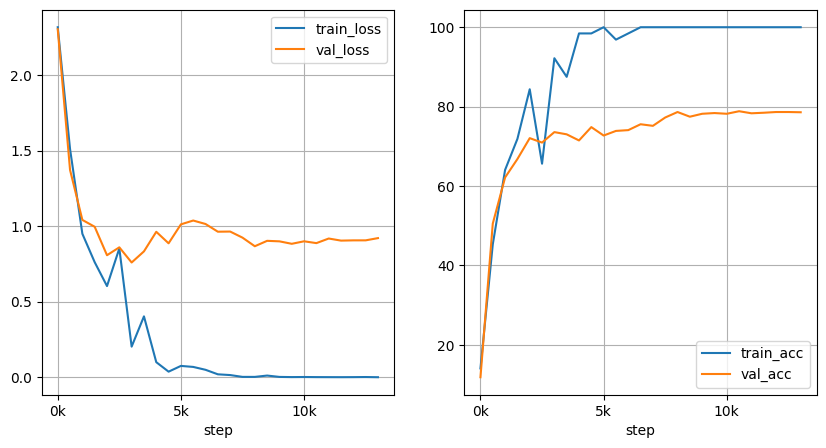

In [20]:
plot_learning_curves(history, sample_step=500)  #横坐标是 steps